Start by importing the package:

In [20]:
import NEST

# List of available models
Each model is a neural network trained on a different evolutionary stellar grid.

In [21]:
NEST.available_models()

BaSTIModel (http://basti-iac.oa-abruzzo.inaf.it/)
PARSECModel (https://stev.oapd.inaf.it/PARSEC/)
MISTModel (https://waps.cfa.harvard.edu/MIST/)
GenevaModel (https://www.unige.ch/sciences/astro/evolution/en/database/syclist/)
DartmouthModel (https://rcweb.dartmouth.edu/stellar/)
YaPSIModel (http://www.astro.yale.edu/yapsi/)
BaSTI_HSTModel (http://basti-iac.oa-abruzzo.inaf.it/)


# Loading a model
By default, the age models use sklearn to run the neural networks. If you do not have it installed, or do not want to use it, you can pass the argument `use_sklearn=False` to switch to a numpy version.

```{note}
Be aware though, in this mode it becomes significantly slower once you run the models on more than ~100 stars
```

In [ ]:
age_model = NEST.BaSTIModel()
#age_model = NNSA.BaSTIModel(use_sklearn=False)

```{tip}
The color and magnitudes are, for most models, in Gaia passbands. Magnitude is $M_G$ and color is $(G_{BP}-G_{RP})$. The only exception is the `BaSTI_HSTModel()`, which uses $F814W$ as magnitude and $(F606W - F814W)$ as color.

If in doubt, print `age_model` to get a description of it.
```

In [23]:
age_model

BaSTI Age Model, Gaia photometry: mag=MG, col=(GBP-GRP).

# Estimating the age of a star
To estimate the age of a star, use the `ages_prediction()` method, and pass it a metallicity met, magnitude mag and color col. Note that, with only these values provided, the return value is a np.array of shape (1,1). The reason will be clear if you check later uses. 

In [24]:
age_model.ages_prediction(met=0.0,mag=2.0,col=1.0)

array([[1.72104573]])

You can use the `check_domain()` method to verify that the star is within the bounds of the isochrones points used for training the neural networks. The function only checks for this in the HR Diagram, so you pass it a metallicity met, magnitude mag and color col.

In [25]:
age_model.check_domain(met=0.0,mag=2.0,col=1.0)

array([ True])

# Estimating the age of a star with GBP & GRP
If you are using Gaia magnitudes and colors, you can also pass the red GRP and blue GBP magnitudes separately as additional inputs. This generally results in better estimations.

In [26]:
age_model.ages_prediction(met=0.0,mag=2.0,col=1.0,GBP=2.0,GRP=1.0)

array([[1.34888727]])

# Estimating the age of multiple stars
If you pass lists of values of size N as inputs instead of single values, the return value of the `ages_prediction()` method will be a np.array of shape (N,1). Again, the reason for the 2D shape will be clear by checking later uses.
```{tip}
If you have tqdm installed, you can display the progress of the age predictions. By default, this display is on, but you can turn it off when you initiate the age_model by passing the argument `use_tqdm=False`.
```

In [27]:
age_model.ages_prediction(
    met=[0.0,-1.0],
    mag=[2.0,3.0],
    col=[1.0,0.5]
)

array([[1.72104573],
       [5.97925446]])

In [28]:
age_model.ages_prediction(
    met=[0.0,-1.0],
    mag=[2.0,3.0],
    col=[1.0,0.5],
    GBP=[2.0,1.0],
    GRP=[1.0,0.5]
)

array([[1.34888727],
       [2.20902813]])

You can also check if the stars are within the training domain all at once by passing lists of metallicity met, magnitude mag & color values col.

In [29]:
age_model.check_domain(
    met=[0.0,-1.0],
    mag=[2.0,3.0],
    col=[1.0,0.5]
)

array([ True,  True])

That way, you can crossmatch both outputs to only keep stars whose age estimates we can reliably trust:

In [30]:
met = [0.0,-1.0,-2.0,-3.0]
mag = [2.0,3.0,3.0,5.0]
col = [1.0,0.5,0.5,0.5]
GBP = [2.0,1.0,1.0,1.0]
GRP = [1.0,0.5,0.5,0.5]
ages = age_model.ages_prediction(met=met,mag=mag,col=col,GBP=GBP,GRP=GRP)
print(ages)
inside_domain = age_model.check_domain(met=met,mag=mag,col=col)
print(inside_domain)
ages = ages[inside_domain]#Only keep ages of stars within the training domain of the NN
print(ages)

[[1.34888727]
 [2.20902813]
 [3.38402904]
 [6.08718654]]
[ True  True  True False]
[[1.34888727]
 [2.20902813]
 [3.38402904]]


# Estimating the age of a star with uncertainties
If you have uncertainty values for a star, you can pass them to the `ages_prediction()` method by adding values for emet, emag & ecol. The idea is that multiple age predictions will be made by offsetting the star's metallicity met, magnitude mag & color col by adding a random gaussian offset of width (emet,emag,ecol). The number of realisations made is controlled by the parameter n. The output of the method will then be a np.array of shape (1,n).

In [31]:
age_model.ages_prediction(met=0.0,mag=2.0,col=1.0,emet=0.1,emag=0.05,ecol=0.05,n=10)

array([[1.69008492, 2.22310332, 2.30607   , 2.52523515, 1.66416769,
        1.68041382, 1.77257101, 1.74791304, 1.79404692, 1.7958949 ]])

Once the ages have been predicted for each star n times, you can call statistical methods `model.mean_ages()`, `model.median_ages()`, `model.mode_ages()` and `model.std_ages()`

In [32]:
print(age_model.mean_ages())
print(age_model.median_ages())
print(age_model.mode_ages())
print(age_model.std_ages())

[1.91995008]
[1.78330896]
[1.68619596]
[0.2942039]


# Estimating the age of multiple stars with uncertainties
Finally, you can combine multiple (N) stars age estimations and added uncertainties, with n Monte Carlo realisations. The output of the `ages_prediction()` method will then be a np.array of shape (N,n). A value of n=100 seems to be a good middle ground between speed and accurate predictions. If the number of stars is low, n>=1000 gives enough realisations to draw a PDF.

In [33]:
age_model.ages_prediction(
    met=[0.0,-1.0],
    mag=[2.0,3.0],
    col=[1.0,0.5],
    emet=[0.1,0.1],
    emag=[0.05,0.05],
    ecol=[0.05,0.05],
    n=10
)

array([[1.81906147, 2.45748128, 1.98144438, 3.26404037, 2.11309181,
        1.90963065, 1.58833429, 1.80982144, 1.75279195, 1.8972145 ],
       [4.73227667, 5.14324081, 6.22592708, 5.11409374, 5.70965976,
        4.81133615, 5.74454807, 6.07974536, 4.85842586, 6.0741056 ]])

In [34]:
print(age_model.mean_ages())
print(age_model.median_ages())
print(age_model.mode_ages())
print(age_model.std_ages())

[2.05929122 5.44933591]
[1.90342258 5.42645028]
[1.61049798 6.08756311]
[0.45861589 0.549749  ]


# Working with big datasets
In the event you are working with big datasets, you might not want to store every sampled age for every star, as you might run out of memory to store all this information.
In this case, you can pass the argument ` store_samples=False ` to the ` age_prediction() ` method. Instead of returning a (N,n) np.array, the method will return a dict with keys ` mean `, ` median `, ` mode ` and ` std `, which each contain a (N) np.array with the given statistical property.

```{note}
Keep in mind this will cause a significant slowdown, as the statistical properties have to be computed for each star individually before discarding all its samples.
```

In [35]:
age_model.ages_prediction(
    met=[0.0,-1.0],
    mag=[2.0,3.0],
    col=[1.0,0.5],
    emet=[0.1,0.1],
    emag=[0.05,0.05],
    ecol=[0.05,0.05],
    n=100,
    store_samples=False
)

{'mean': array([2.07097338, 5.81777863]),
 'median': array([1.75000115, 5.96110458]),
 'mode': array([1.675, 6.475]),
 'std': array([0.84768186, 0.8482442 ])}

# Age model properties
- `age_model.samples` returns an (N,n,m) np.array of the latest samples used for the age predictions, if they were stored.
- `age_model.ages` returns an (N,n) np.array of the latest age predictions ran.
N : number of stars, n : number of samples, m : inputs dimension (3 if using metallicity,magnitude & color, 5 if using GBP & GRP in addition).

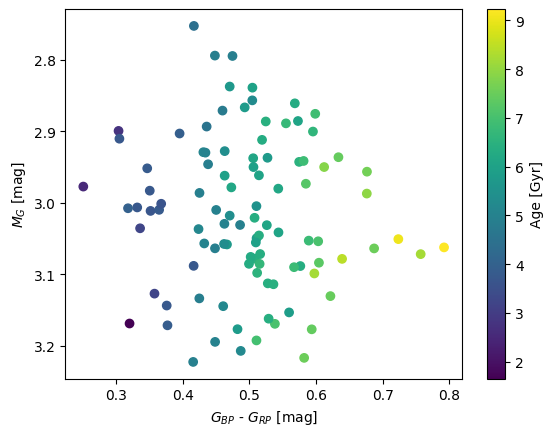

In [36]:
#Here is an example on how you can retrieve the samples
#of the age predictions to investigate individual predictions
age_model.ages_prediction(
    met=[0.0,-1.0],
    mag=[2.0,3.0],
    col=[1.0,0.5],
    emet=[0.1,0.1],
    emag=[0.1,0.1],
    ecol=[0.1,0.1],
    n=100
)

star_i = 1#Select the second star
magnitudes = age_model.samples[star_i,:,1]
colors = age_model.samples[star_i,:,2]
ages = age_model.ages[star_i]

import matplotlib.pyplot as plt
plt.scatter(colors,magnitudes,c=ages)
plt.colorbar(label='Age [Gyr]')
plt.xlabel(r'$G_{BP}$ - $G_{RP}$ [mag]')
plt.ylabel(r'$M_G$ [mag]')
plt.ylim(plt.ylim()[::-1]);

# Plotting an HR Diagram

```{warning}
You need the matplotlib package for this function.
```

To visualize your star sample in an HR Diagram, you can use the `HR_diagram()` method. It plots your stars, colored by their estimated age. It also plots isochrones from the evolutionary grid the age model Neural Network was trained on.

```{note}
By default, the curve data is not included in the NEST package, so the first time, you will be prompted to download them (15.6Mb).
```

This method is very flexible in its arguments. You can pass it:
- nothing if you already ran `ages_prediction()` with `store_samples=True`
- `met`,`mag`,`col` and it will compute the ages
- `mag`,`col`,`ages` and it will use the ages provided

The `isochrone_met` option lets you choose which set of isochrones will be plotted. You can choose between [M/H] = {-2,1,0}. The `age_type` option lets you choose the type of ages used to color the stars, between `'median'`, `'mean'` and `'mode'`. Finally, the `check_domain` option restricts the plotted stars to stars being in the domain of the training grid (`true` by default).

```{tip}
In an interactive matplotlib backend, you can hover over the isochrones to get their age. 
```

[-0.32127972 -1.94498436 -0.49712305 -1.95264323 -1.52635356 -1.99187031
 -0.92846815 -1.95504969 -0.33957069 -0.86570884 -0.74868447 -1.43782219
 -1.38942308 -0.57602733 -1.42918902 -0.03062132 -0.47874858 -0.58103346
 -0.80694701 -1.0324925  -0.54192474 -0.64078898 -1.65447699 -0.08507601
 -0.60418409 -1.47305636 -0.77702417 -0.94760187 -1.46541365 -0.32021805
 -0.17220602 -0.27339968 -0.1626988  -1.84579341 -0.02938594 -1.49322095
 -0.79236661 -1.17601767 -0.70350461 -1.02201562 -1.66883228 -0.6572283
 -1.16748316 -1.2664032  -1.2748056  -0.41492059 -1.37578459 -1.36834622
 -0.59145993 -0.18256234 -1.63485763 -1.58045589 -0.6329881  -1.59577602
 -1.92867596 -1.71552762 -0.56767161 -1.11247534 -1.45083721 -1.25862752
 -0.07600204 -1.83104084 -1.88662088 -0.28154779 -1.63160081 -1.80036339
 -0.56657154 -0.37365115 -0.47713915 -0.72759991 -1.09324491 -1.99814619
 -1.17358535 -1.88677207 -1.07271124 -1.96481188 -0.5776946  -0.15934468
 -1.37939531 -0.87726434 -0.55067214 -0.98225361 -0.

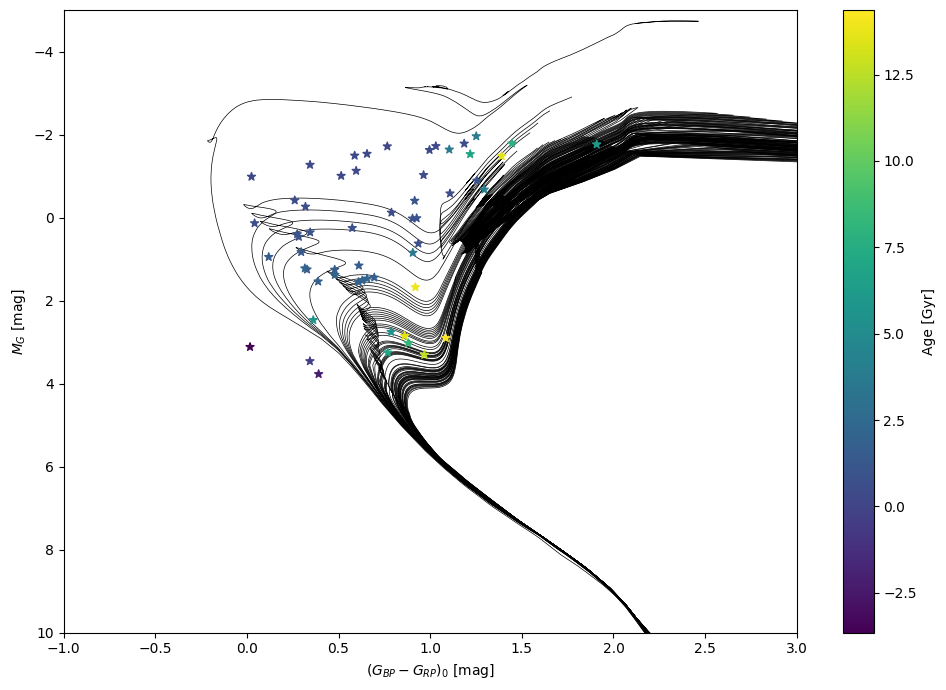

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

age_model = NEST.BaSTIModel()
met = np.random.uniform(-2, 0, size=100)
mag = np.random.uniform(-2, 4, size=100)
col = np.random.uniform( 0, 2, size=100)
age_model.HR_diagram(met,mag,col)